In [8]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *
import utils.BayesSpace
reload(utils.BayesSpace)
from utils.BayesSpace import Xenium_to_BayesSpace

In [2]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')
df_transcripts.head()

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv
0,281474976710657,191815,1,LUM,4797.2383,550.61346,15.421524,18.445875
1,281474976710663,214084,1,SEC11C,4801.7330,905.11600,14.925031,31.019386
2,281474976710672,191342,0,TCIM,4804.4920,596.05396,14.681485,22.270780
3,281474976710673,191574,0,STC1,4805.0483,414.38370,19.306356,16.183300
4,281474976710674,192193,0,STC1,4805.7170,273.81440,16.112896,26.251837


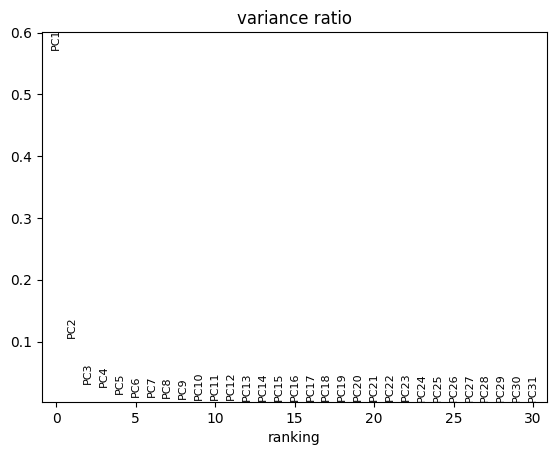

        highly_variable     means  dispersions  dispersions_norm
ABCC11             True  0.783410     1.701554          0.671810
ACTA2              True  1.339726     2.501664          1.074146
ACTG2              True  0.647614     1.481535          0.261175
ADAM9             False  0.783937     0.814381         -0.983971
ADGRE5            False  0.204589     0.665238         -0.726379
...                 ...       ...          ...               ...
VWF                True  0.602005     2.528375          1.879303
WARS              False  0.496454     0.671346         -1.214906
ZEB1               True  0.478715     0.890358         -0.414168
ZEB2               True  0.794795     1.363296          0.040499
ZNF562            False  0.880522     0.992827         -0.845783

[541 rows x 4 columns]
        highly_variable     means  dispersions  dispersions_norm
ABCC11             True  0.783410     1.701554          0.671810
ACTA2              True  1.339726     2.501664          1.074146
A

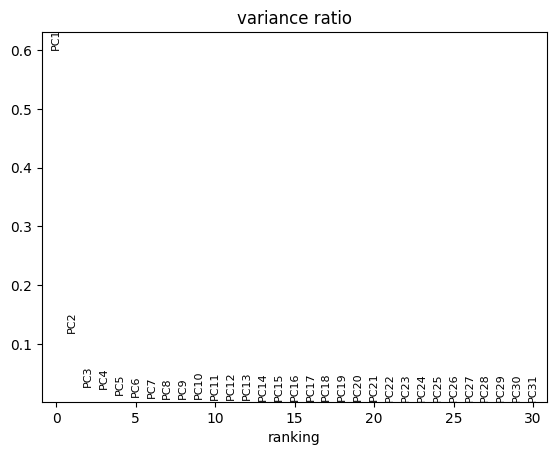

        highly_variable     means  dispersions  dispersions_norm
ABCC11             True  1.725711     2.603242          1.056996
ACTA2              True  2.480069     3.378822          1.451598
ACTG2              True  1.512324     2.357516          0.241812
ADAM9             False  1.726509     1.599566         -1.400506
ADGRE5             True  0.632074     1.172139         -0.389919
...                 ...       ...          ...               ...
VWF                True  1.436614     3.046879          1.497228
WARS              False  1.251700     1.356287         -0.727607
ZEB1              False  1.219093     1.466481         -0.553164
ZEB2               True  1.742890     2.073967         -0.238935
ZNF562            False  1.869232     1.976891         -0.811635

[541 rows x 4 columns]
        highly_variable     means  dispersions  dispersions_norm
ABCC11             True  1.725711     2.603242          1.056996
ACTA2              True  2.480069     3.378822          1.451598
A

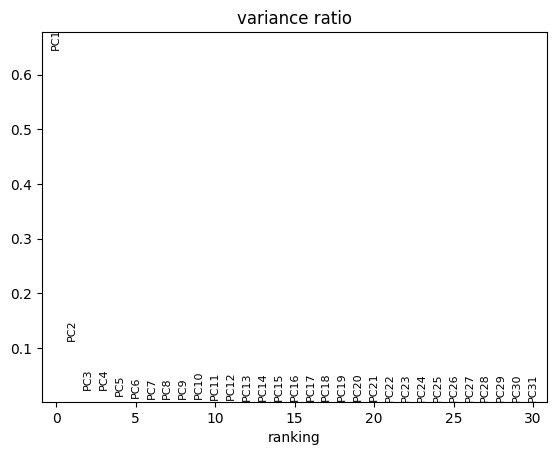

        highly_variable     means  dispersions  dispersions_norm
ABCC11             True  2.424792     3.249498          0.776208
ACTA2              True  3.235256     3.898473          0.822678
ACTG2              True  2.185149     2.905960          0.529130
ADAM9             False  2.425677     2.210346         -1.831098
ADGRE5            False  1.087461     1.580729         -0.795270
...                 ...       ...          ...               ...
VWF                True  2.098491     3.332760          1.065001
WARS              False  1.882429     1.867566         -1.248259
ZEB1              False  1.843592     1.938246         -0.509194
ZEB2              False  2.443826     2.589414         -0.879990
ZNF562            False  2.582775     2.672991         -0.670288

[541 rows x 4 columns]
        highly_variable     means  dispersions  dispersions_norm
ABCC11             True  2.424792     3.249498          0.776208
ACTA2              True  3.235256     3.898473          0.822678
A

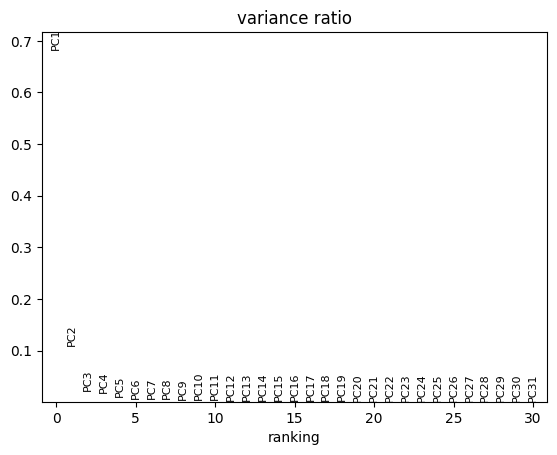

        highly_variable     means  dispersions  dispersions_norm
ABCC11             True  2.953047     3.744833          1.381699
ACTA2              True  3.785395     4.306623          0.855501
ACTG2              True  2.702556     3.293917          0.277550
ADAM9             False  2.953967     2.696406         -1.940498
ADGRE5            False  1.497032     1.916026         -0.848539
...                 ...       ...          ...               ...
VWF                True  2.611254     3.533479          0.757073
WARS              False  2.381575     2.321132         -1.226039
ZEB1              False  2.339939     2.323384         -0.513577
ZEB2              False  2.972831     2.989003         -1.106574
ZNF562            False  3.116835     3.195917         -0.516851

[541 rows x 4 columns]
         highly_variable     means  dispersions  dispersions_norm
ABCC11              True  2.953047     3.744833          1.381699
ACTA2               True  3.785395     4.306623          0.85550

In [9]:
for spot_size in [25, 50, 75, 100]:

    clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
    clustering.set_spot_size(spot_size)
    clustering.create_spot_data(third_dim=False, save_data=True)

    clustering.normalize_counts(clustering.xenium_spot_data)
    clustering.filter_only_high_variable_genes(clustering.xenium_spot_data)
    # generate the neigborhood graph based on pca
    sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack')
    sc.pl.pca_variance_ratio(clustering.xenium_spot_data)
    print(clustering.xenium_spot_data.var)
    clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]
    print(clustering.xenium_spot_data.var)

    Xenium_to_BayesSpace(clustering.xenium_spot_data, spot_size)